# CMM 513 M.Sc Project 
## Prediction of the Brent Oil Closing Price using Machine Learning 
### Dayo Adebayo - 1610762
### M.Sc (Hons) Data Science, RGU

# PART 1: Data Loading/Compilation 

Introduction of My datasets

The original datasets are obtained from the Yahoo Finance website [here](https://finance.yahoo.com/quote/BZ=F/history?period1=1310871600&period2=1626663599&interval=1d&frequency=1d&filter=history)

My created clean dataset is [here](https://1drv.ms/u/s!Atyqwr17kqRhhd0hoUCv5VcuacdX4g?e=J8WbKm)

In [1]:
## Importing the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
#import pandas_datareader as web
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from keras.layers import Dropout
from keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Loading my dataset
dataset = pd.read_csv('/Users/Brent_historical_data.csv')
dataset = dataset.dropna(how='any',axis=0) 

In [3]:
# Having a glimpse of my dataset
print ('Shape of data', dataset.shape)
dataset.head()

Shape of data (3509, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,30/07/2007,75.849998,76.529999,75.440002,75.739998,75.739998,2575.0
1,31/07/2007,75.699997,77.169998,75.669998,77.050003,77.050003,3513.0
2,01/08/2007,77.000000,77.059998,74.860001,75.349998,75.349998,3930.0
3,02/08/2007,75.220001,76.209999,74.269997,75.760002,75.760002,6180.0
4,03/08/2007,75.389999,76.000000,74.529999,74.750000,74.750000,4387.0


In [4]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3594,03/11/2021,81.32,84.50,80.19,80.54,80.54,72626.0
3595,04/11/2021,81.00,83.15,80.27,82.74,82.74,43130.0
3596,08/11/2021,82.57,83.99,82.50,83.43,83.43,27655.0
3597,09/11/2021,83.59,85.14,83.18,84.78,84.78,34996.0
3598,10/11/2021,85.16,85.50,82.09,82.64,82.64,34996.0


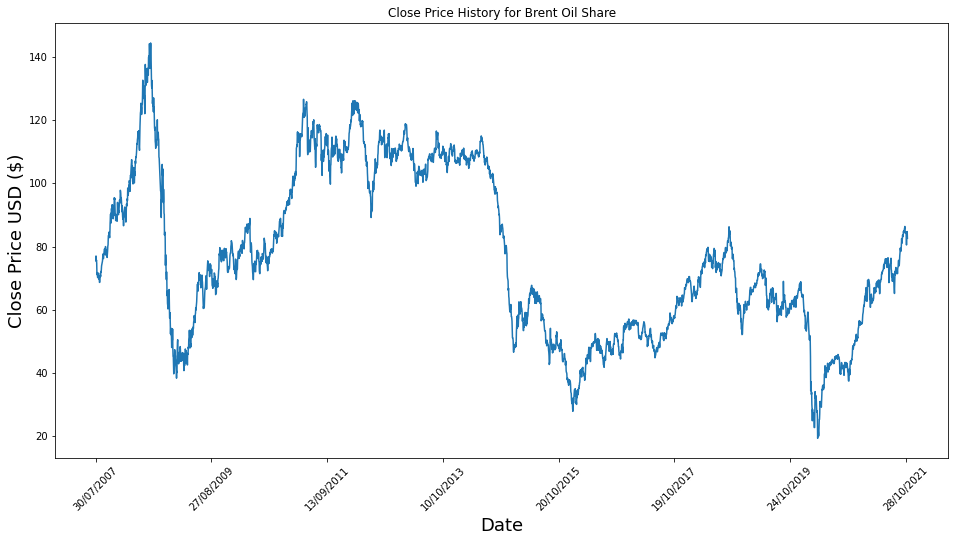

In [5]:
plt.figure(figsize=(16,8))
plt.title('Close Price History for Brent Oil Share')
plt.plot(range(dataset.shape[0]),(dataset['Close']))
plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [6]:
#Convert pandas dataframe to numpy array
dataset4 = dataset.filter(['Close'])
dataset4 = dataset4.values
#dataset4 = dataset4.astype('float32') #Convert values to float

In [7]:
# We cannot use random way of splitting dataset into train and test as
# the sequence of events is important for time series.
# So let us take first 80% values for train and the remaining 20% for testing
# split into train and test sets
train_size = int(len(dataset4) * 0.8)
test_size = len(dataset4) - train_size
train, test = dataset4[0:train_size,:], dataset4[train_size:len(dataset4),:]

In [8]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
scaled_data = scaler.fit_transform(dataset4)

scaled_data

array([[0.45070307],
       [0.46116971],
       [0.44758705],
       ...,
       [0.51214443],
       [0.52293063],
       [0.50583251]])

In [9]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:train_size , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train =[]

for i in range (80, len(train_data)):
    x_train.append(train_data[i-80:i, 0])
    y_train.append(train_data[i, 0])
    if i <= 80:
        print(x_train)
        print(y_train)
        print()

[array([0.45070307, 0.46116971, 0.44758705, 0.45086289, 0.44279321,
       0.4141898 , 0.4192234 , 0.41275165, 0.40651963, 0.40795779,
       0.40667946, 0.40891659, 0.41794501, 0.40300411, 0.4083573 ,
       0.4036433 , 0.3943752 , 0.39445506, 0.40372323, 0.40979547,
       0.41243205, 0.40923619, 0.42185998, 0.42002237, 0.42633429,
       0.43616168, 0.43951737, 0.44295298, 0.44534993, 0.44862577,
       0.45581651, 0.46620324, 0.46172899, 0.45453818, 0.46061042,
       0.46548413, 0.47251517, 0.47746879, 0.4791467 , 0.47603069,
       0.46572388, 0.4642058 , 0.4849792 , 0.47810799, 0.46588364,
       0.46380629, 0.46380629, 0.47651006, 0.47595078, 0.45741451,
       0.46468517, 0.47355382, 0.485938  , 0.48913391, 0.50671139,
       0.51310323, 0.50974748, 0.52149245, 0.51502076, 0.51086605,
       0.50751035, 0.51965485, 0.54450304, 0.55417066, 0.56719397,
       0.54418344, 0.56967077, 0.56240011, 0.58125599, 0.56855221,
       0.59068392, 0.59052409, 0.58692872, 0.59004472, 0.5804

In [10]:
# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2727, 80, 1)

In [12]:
# Build my LSTM model
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

Single LSTM with hidden Dense...


In [13]:
# Compile my model
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp2u1lredw.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp2u1lredw.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2727/2727 [==============================] - 125s 40ms/step - loss: 0.0043


In [15]:
# Create the testing data set
# Create a new array containing scaled values from index 2868 to 3585
test_data = scaled_data[train_size - 80: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset4[train_size:, :]
for i in range(80, len(test_data)):
    x_test.append(test_data[i-80:i, 0])

In [16]:
# Convert the data to a numpy array 
x_test = np.array(x_test)

In [17]:
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(702, 80, 1)

In [18]:
# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [19]:
# Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean( predictions - y_test )**2 )
rmse

1.9588307331071728

<ipython-input-20-8710124e3a8f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


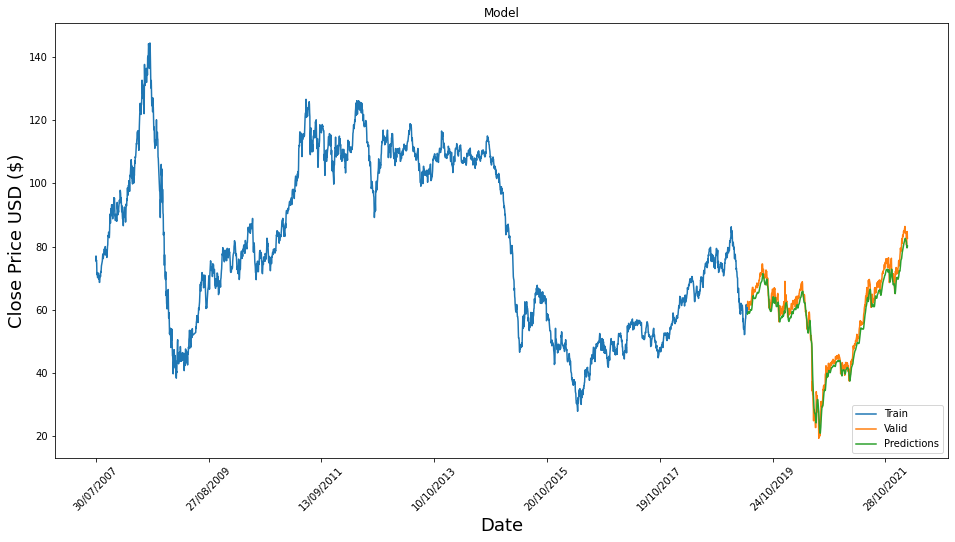

In [20]:
# Plot the data
train = dataset[:train_size]
valid = dataset[train_size:]
valid['Predictions'] = predictions
# Visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(range(0,dataset.shape[0],500),dataset['Date'].loc[::500],rotation=45)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='lower right')
plt.show()

In [21]:
# Show the valid and predicted prices
valid

,Date,Open,High,Low,Close,Adj Close,Volume,Predictions
2889,17/01/2019,61.180000,61.540001,60.040001,61.180000,61.180000,30131.0,58.636253
2890,18/01/2019,61.189999,62.990002,61.060001,62.700001,62.700001,39637.0,58.800968
2891,22/01/2019,62.740002,63.119999,60.580002,61.500000,61.500000,53602.0,59.226780
2892,23/01/2019,61.570000,62.299999,60.220001,61.139999,61.139999,35364.0,59.418468
2893,24/01/2019,61.020000,61.500000,60.410000,61.090000,61.090000,35861.0,59.405979
...,...,...,...,...,...,...,...,...
3594,03/11/2021,81.320000,84.500000,80.190000,80.540000,80.540000,72626.0,81.060234
3595,04/11/2021,81.000000,83.150000,80.270000,82.740000,82.740000,43130.0,80.054199
3596,08/11/2021,82.570000,83.990000,82.500000,83.430000,83.430000,27655.0,79.625130
3597,09/11/2021,83.590000,85.140000,83.180000,84.780000,84.780000,34996.0,79.659447


In [22]:
# Get the the quote
oil_quote = pd.read_csv('/Users/Brent_historical_data.csv')
oil_quote = oil_quote.dropna(how='any',axis=0) 
# Create a new dataframe
new_df = oil_quote.filter(['Close'])
# Get the last 80 days closing price values and convert the dataframe to an array
last_80_days = new_df[-80:].values
# Scale the data to be values between 0 and 1
last_80_days_scaled = scaler.transform(last_80_days)
# Create an empty list
X_test = []
# Append the past 80 days
X_test.append(last_80_days_scaled)
# Convert the X_test data to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[[80.289856]]


The ARIMA Model

In [23]:
# evaluate an ARIMA model using a walk-forward validation
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
dataset = pd.read_csv('/Users/Brent_historical_data.csv', index_col='Date', parse_dates=True)
dataset = dataset.dropna(how='any',axis=0) 
# Having a glimpse of my dataset
print ('Shape of data', dataset.shape)
dataset.head()

Shape of data (3509, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575.0
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513.0
2007-01-08,77.000000,77.059998,74.860001,75.349998,75.349998,3930.0
2007-02-08,75.220001,76.209999,74.269997,75.760002,75.760002,6180.0
2007-03-08,75.389999,76.000000,74.529999,74.750000,74.750000,4387.0


In [24]:
# Check for Stationarity
def ad_test(data):
    datasetTest = adfuller(data, autolag = 'AIC')
    print("1. ADF : ", datasetTest[0])
    print("2. P-Value : ", datasetTest[1])
    print("3. Num of Lags : ", datasetTest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Values Calculation : ", datasetTest[3])
    print("5. Critical Values : ",)
    for key, val in datasetTest[4].items():
        print("\t", key, ": ", val)

In [25]:
ad_test(dataset['Close'])

1. ADF :  -1.7524325789100328
2. P-Value :  0.4043199697796198
3. Num of Lags :  4
4. Num of Observations Used for ADF Regression and Critical Values Calculation :  3504
5. Critical Values : 
	 1% :  -3.432217607589796
	 5% :  -2.862365203080607
	 10% :  -2.5672092698787816


In [26]:
# Figure Out Order for ARIMA Model
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
stepwise_fit = auto_arima(dataset['Close'], trace=True,
                         suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13050.870, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13057.149, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13052.275, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13051.970, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13055.155, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13054.600, Time=1.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13054.357, Time=0.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13052.405, Time=1.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13052.444, Time=2.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13053.376, Time=0.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13041.845, Time=2.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13053.783, Time=0.42 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=13049.050, Time=1.34 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13052.753, Time=0.28 sec
 ARIMA(0,1,4)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3509
Model:               SARIMAX(1, 1, 3)   Log Likelihood               -6514.924
Date:                Mon, 22 Nov 2021   AIC                          13039.848
Time:                        10:00:18   BIC                          13070.662
Sample:                             0   HQIC                         13050.844
                               - 3509                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9680      0.015     64.373      0.000       0.938       0.997
ma.L1         -1.0172      0.019    -52.820      0.000      -1.055      -0.979
ma.L2          0.0259      0.017      1.494      0.135      -0.008       0.060
ma.L3          0.0363      0.013      2.783      0.005       0.011       0.062
sigma2         2.4023      0.032     74.450      0.000       2.339       2.466
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2994.25
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# Splitting my dataset
print(dataset.shape)
train=dataset.iloc[:-20]
test=dataset.iloc[-20:]
print(train.shape,test.shape)

(3509, 6)
(3489, 6) (20, 6)


In [29]:
# Calling my ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train['Close'],order=(1,1,3))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 3488
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -6481.844
Method:                       css-mle   S.D. of innovations              1.552
Date:                Mon, 22 Nov 2021   AIC                          12975.688
Time:                        10:00:19   BIC                          13012.630
Sample:                             1   HQIC                         12988.874
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0030      0.037      0.082      0.935      -0.070       0.076
ar.L1.D.Close     0.9683      0.014     70.071      0.000       0.941       0.995
ma.L1.D.Close    -1.0175      0.022    -46.706      0.000      -1.060      -0.975
ma.L2.D.Close     0.0268      0.024      1.125      0.261      -0.020       0.073
ma.L3.D.Close     0.0356      0.016      2.161      0.031       0.003       0.068
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0328           +0.0000j            1.0328            0.0000
MA.1            1.0528           +0.0000j            1.0528            0.0000
MA.2            4.3423           +0.0000j            4.3423            0.0000
MA.3           -6.1468           +0.0000j            6.1468            0.5000
-----------------------------------------------------------------------------
"""

In [30]:
# To check how good is my ARIMA Model
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.index=dataset.index[start:end+1]
print(pred)

Date
2021-10-13    83.522037
2021-10-14    83.655736
2021-10-15    83.775434
2021-10-18    83.891428
2021-10-19    84.003836
2021-10-20    84.112771
2021-10-21    84.218345
2021-10-24    84.320663
2021-10-25    84.419829
2021-10-26    84.515944
2021-10-27    84.609103
2021-10-28    84.699401
2021-10-31    84.786928
2021-01-11    84.871773
2021-02-11    84.954021
2021-03-11    85.033754
2021-04-11    85.111052
2021-08-11    85.185992
2021-09-11    85.258649
2021-10-11    85.329096
Name: ARIMA Predictions, dtype: float64


<AxesSubplot:xlabel='Date'>

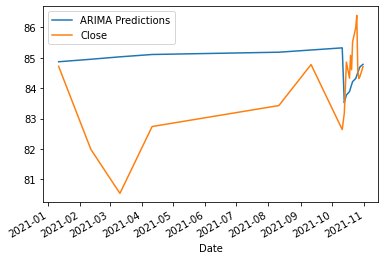

In [31]:
pred.plot(legend=True)
test['Close'].plot(legend=True)

In [32]:
# Checking my accuracy metric
from sklearn.metrics import mean_squared_error
from math import sqrt
print('ARIMA Model Mean Value is : ', test['Close'].mean())

ARIMA Model Mean Value is :  84.1405


In [33]:
rmse=sqrt(mean_squared_error(pred,test['Close']))
print('ARIMA Model Accuracy : ', rmse)

ARIMA Model Accuracy :  1.6852497956016417


In [34]:
# Calling my ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
model2=ARIMA(dataset['Close'],order=(1,1,3))
model2=model2.fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 3508
Model:                 ARIMA(1, 1, 3)   Log Likelihood               -6514.922
Method:                       css-mle   S.D. of innovations              1.550
Date:                Mon, 22 Nov 2021   AIC                          13041.845
Time:                        10:03:33   BIC                          13078.822
Sample:                             1   HQIC                         13055.040
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.037      0.053      0.958      -0.070       0.074
ar.L1.D.Close     0.9680      0.014     69.335      0.000       0.941       0.995
ma.L1.D.Close    -1.0172      0.022    -46.579      0.000      -1.060      -0.974
ma.L2.D.Close     0.0259      0.024      1.095      0.274      -0.020       0.072
ma.L3.D.Close     0.0363      0.016      2.210      0.027       0.004       0.068
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0331           +0.0000j            1.0331            0.0000
MA.1            1.0530           +0.0000j            1.0530            0.0000
MA.2            4.3083           +0.0000j            4.3083            0.0000
MA.3           -6.0764           +0.0000j            6.0764            0.5000
-----------------------------------------------------------------------------
"""

In [36]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-11,81.32,84.50,80.19,80.54,80.54,72626.0
2021-04-11,81.00,83.15,80.27,82.74,82.74,43130.0
2021-08-11,82.57,83.99,82.50,83.43,83.43,27655.0
2021-09-11,83.59,85.14,83.18,84.78,84.78,34996.0
2021-10-11,85.16,85.50,82.09,82.64,82.64,34996.0


In [47]:
index_future_dates=pd.date_range(start='2021-11-10', end='2021-12-10')
#print(index_future_dates)
pred=model2.predict(start=len(dataset),end=len(dataset)+30,typ='levels').rename('ARIMA Predictions')
pred.index=index_future_dates
print(pred)

2021-11-10    82.749978
2021-11-11    82.854408
2021-11-12    82.880028
2021-11-13    82.904889
2021-11-14    82.929016
2021-11-15    82.952433
2021-11-16    82.975162
2021-11-17    82.997225
2021-11-18    83.018644
2021-11-19    83.039439
2021-11-20    83.059631
2021-11-21    83.079238
2021-11-22    83.098279
2021-11-23    83.116773
2021-11-24    83.134736
2021-11-25    83.152187
2021-11-26    83.169141
2021-11-27    83.185614
2021-11-28    83.201622
2021-11-29    83.217179
2021-11-30    83.232300
2021-12-01    83.247000
2021-12-02    83.261291
2021-12-03    83.275186
2021-12-04    83.288699
2021-12-05    83.301841
2021-12-06    83.314625
2021-12-07    83.327061
2021-12-08    83.339162
2021-12-09    83.350937
2021-12-10    83.362398
Freq: D, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:>

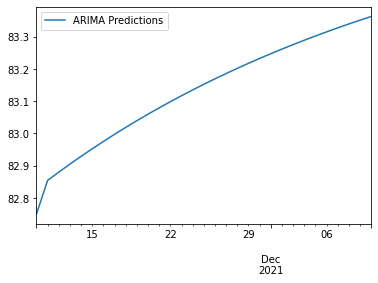

In [49]:
pred.plot(legend=True)
